## Introduction
This notebook will implement a rolling out of sample forecast on time series data.  The aim of this notebook is to set up the initial infrastructure while allowing for subsequent iteration.  Getting the piping to work, so to speak.  Subsequent iterations will add an inner loop allowing for nested cross validation.  This will be used to tune hyper-parameters in a time series context.  

We will forecast the S&P500 index using an Elastic net logistic regression.  This will be implemented using Scikit Learn's `SGDClassifier` specifying the loss function "log" and penalty "elasticnet".  This specification will result in a regularised logistic regression whereby parameter may be excluded from the model via the shrinkage operator.

A key output of the notebook is a time series of the co-efficients of the  parameters included in model.  This will allow for assessment of the stability of the model over time.  



In [0]:
# Import required libraries
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import datetime
import math
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams["figure.figsize"] = (12, 8)
import sklearn.metrics as metrics
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

The data.  It comes from [this](https://brentmorrison.netlify.com/post/financial-data-aggregator/) R script.  The data contains an attribute `y1`, which is a binary indicator that looks forward over the next 6 months and returns 1 if the maximum drawdown is more than 20% or the return is less than 2.5%.  

Below we convert dates stored as string to the datetime format and then set this date as the index.

In [2]:
# Read csv fle from github
url = 'https://raw.githubusercontent.com/Brent-Morrison/Misc_scripts/master/econ_fin_data.csv'
df_raw = pd.read_csv(url)

# Convert date to datetime and create month end date
df_raw['date'] = pd.to_datetime(df_raw['date'], format='%Y-%m-%d')
df_raw['me_date'] = pd.Index(df_raw['date']).to_period('M').to_timestamp('M')

# Set date as index in new df
df = df_raw.set_index('me_date')

# Inspect csv data - shape
df.shape

(899, 47)

Some simple feature engineering for attributes that may forecast stock returns.  We are not too concerned about the data and model form at this stage. Remember we are just getting the piping to work.

In [3]:
# Creation of attributes
df = df.assign(
    CRED_SPRD = df.BAA - df.AAA
    ,YLD_SPRD = df.GS10 - df.FEDFUNDS
    ,LOAN_GROWTH = np.log(df.LOANS / df.LOANS.shift(6))
    )

# Inspect csv data - first and last records
df.iloc[np.r_[0:4, len(df) - 4:len(df)],]

,date,AAA,ACDGNO,AHETPI,AWHMAN,BAA,BOGMBASE,CFNAIDIFF,CPIAUCSL,CPILFESL,FEDFUNDS,GS10,GS2,INDPRO,ISRATIO,KCFSI,LOANS,M2SL,NEWORDER,PERMIT,TB3MS,TWEXMMTH,UNRATE,IC4WSA,NEWORD,HMI,P,D,E,CPI,Fraction,Rate.GS10,Price,Dividend,Earnings,CAPE,low,close,volume,rtn_m,fwd_rtn_m,rtn_6m,min_6m,dd_6m,flag,y1,diff_flag,CRED_SPRD,YLD_SPRD,LOAN_GROWTH
me_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1945-01-31,1945-01-01,2.69,NaN,NaN,45.5,3.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.8372,NaN,NaN,NaN,NaN,NaN,NaN,0.38,NaN,NaN,NaN,NaN,NaN,13.490000,0.643333,0.940000,17.8000,1945.041667,2.370,189.448293,9.034717,13.200993,11.960463,13.210000,13.470000,0,0.000000,0.059795,NaN,NaN,NaN,NaN,0.0,NaN,0.77,NaN,NaN
1945-02-28,1945-02-01,2.65,NaN,NaN,45.5,3.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.7818,NaN,NaN,NaN,NaN,NaN,NaN,0.38,NaN,NaN,NaN,NaN,NaN,13.940000,0.646667,0.950000,17.8000,1945.125000,2.355,195.767917,9.081539,13.341429,12.341754,13.500000,14.300000,0,0.059795,-0.049455,NaN,NaN,NaN,NaN,0.0,0.0,0.76,NaN,NaN
1945-03-31,1945-03-01,2.62,NaN,NaN,45.3,3.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.6710,NaN,NaN,NaN,NaN,NaN,NaN,0.38,NaN,NaN,NaN,NaN,NaN,13.930000,0.650000,0.960000,17.8000,1945.208333,2.340,195.627481,9.128346,13.481865,12.323310,13.390000,13.610000,0,-0.049455,0.086521,NaN,NaN,NaN,NaN,0.0,0.0,0.76,NaN,NaN
1945-04-30,1945-04-01,2.61,NaN,NaN,45.0,3.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.3664,NaN,NaN,NaN,NaN,NaN,NaN,0.38,NaN,NaN,NaN,NaN,NaN,14.280000,0.650000,0.973333,17.8000,1945.291667,2.325,200.542744,9.128346,13.669109,12.631867,13.670000,14.840000,0,0.086521,0.011390,NaN,NaN,NaN,NaN,0.0,0.0,0.75,NaN,NaN
2019-08-31,2019-08-01,2.98,44576.0,23.60,41.5,3.87,3271378.0,-0.09,256.300,264.245,2.13,1.63,1.57,109.9273,1.4,-0.33,9883.1084,14930.9,68901.0,1425.0,1.95,92.2746,3.7,216750.0,47.2,67.0,2897.498182,56.839092,134.063333,256.5580,2019.625000,1.630,2909.712357,57.078692,134.628467,28.704955,2822.120117,2926.459961,79599440000,-0.018257,0.017035,0.049729,2722.270020,-0.022599,0.0,NaN,NaN,0.89,-0.50,0.022257
2019-09-30,2019-09-01,3.03,43233.0,23.67,41.5,3.91,3202682.0,-0.24,256.358,264.595,2.04,1.70,1.65,109.5940,1.4,-0.35,9902.6579,15028.3,68533.0,1391.0,1.89,92.6991,3.5,212750.0,47.3,68.0,2982.156000,57.220000,133.460000,256.7590,2019.708333,1.700,2992.382665,57.416224,133.917673,29.228182,2891.850098,2976.739990,73992330000,0.017035,0.020226,0.048998,2728.810059,-0.037965,0.0,NaN,NaN,0.88,-0.34,0.019858
2019-10-31,2019-10-01,3.01,42476.0,23.76,41.4,3.92,3252830.0,-0.22,257.271,265.011,1.83,1.71,1.55,108.6714,1.4,-0.51,9931.7438,15195.0,69267.0,1461.0,1.65,92.3729,3.6,215000.0,49.1,71.0,2977.680000,NaN,NaN,257.3460,2019.791667,1.710,2981.076008,NaN,NaN,28.838509,2855.939941,3037.560059,77564550000,0.020226,0.033480,0.030664,2728.810059,-0.076525,0.0,NaN,NaN,0.91,-0.12,0.020239
2019-11-30,2019-11-01,3.06,42476.0,23.83,41.4,3.94,3315603.0,-0.22,NaN,NaN,1.55,1.81,1.61,NaN,1.4,NaN,NaN,NaN,NaN,NaN,1.54,92.4113,3.5,217750.0,47.2,70.0,3120.460000,NaN,NaN,257.6395,2019.875000,1.820,3120.460000,NaN,NaN,30.008420,3050.719971,3140.979980,72179920000,0.033480,0.001568,0.132185,2728.810059,-0.008484,0.0,NaN,NaN,0.88,0.26,NaN


To the modelling.  Select the attributes to be predictors and label in our model.

In [0]:
# List variables  
# Dependent variable
dep_var = ['y1']
# Predictors/ independent variables
ind_vars = ['CRED_SPRD', 'YLD_SPRD', 'LOAN_GROWTH', 'rtn_6m']
# Other variables to be used in the plot
oth_vars = ['close']
vars = dep_var + ind_vars + oth_vars
df = df[vars]

Our new data frame.

In [5]:
# Drop na' when variables are not null / Nan
df = df.dropna(subset = vars)

# Inspect csv data - first and last records
df.iloc[np.r_[0:4, len(df) - 4:len(df)],]

,y1,CRED_SPRD,YLD_SPRD,LOAN_GROWTH,rtn_6m,close
me_date,,,,,,
1954-07-31,0.0,0.61,1.50,0.006512,0.168940,30.879999
1954-08-31,0.0,0.62,1.14,0.016628,0.131665,29.830000
1954-09-30,0.0,0.58,1.32,0.019759,0.181765,32.310001
1954-10-31,0.0,0.59,1.58,0.026823,0.114238,31.680000
2019-03-31,0.0,1.07,0.16,0.029602,-0.027690,2834.399902
2019-04-30,0.0,1.01,0.11,0.028409,0.082800,2945.830078
2019-05-31,0.0,0.96,0.01,0.028386,-0.002943,2752.060059
2019-06-30,0.0,1.04,-0.31,0.025044,0.159981,2941.760010


Lets get modelling.  The variables defined in the next cell inform the training and testing ranges.

In [0]:
# Set training and testing ranges
train_length = 300
test_length = 4
loops = math.floor((len(df) - train_length) / test_length)
start = len(df) - (loops * test_length + train_length)
stop = math.floor((len(df) - train_length) / test_length) * test_length

# Empty objects
y_pred_prob = None
model_coef = None

The training, testing loop.  This piece of code selects a training subset, fits a model and then applies that model to new unseen data.  Predicted probabilities, and parameter co-efficients are returned to a dataframe.  

In [0]:
# Training loop
for i in range(start, stop, test_length):

    # Model data
    y_train_raw = np.array(df.iloc[i:i + train_length, 0])
    x_train_raw = np.array(df.iloc[i:i + train_length, 1:len(vars) - 1])
    y_test_raw = np.array(df.iloc[i + train_length:i + train_length + test_length, 0])
    x_test_raw = np.array(df.iloc[i + train_length:i + train_length + test_length, 1:len(vars) - 1])

    # Scale for model ingestion
    sc = StandardScaler()
    x_train = sc.fit_transform(x_train_raw)

    # Apply mean and standard deviation from transform applied to training data to test data
    x_test = sc.transform(x_test_raw)

    # Specify model
    sgd = linear_model.SGDClassifier(
        loss = 'log'
        ,penalty = 'elasticnet'
        ,max_iter = 2500
        ,n_iter_no_change = 500
        ,tol = 1e-3)

    # Train model
    sgd.fit(x_train, y_train_raw)

    # Predict on test data and write to array
    y_pred = sgd.predict_proba(x_test)
    if y_pred_prob is None:
        y_pred_prob = y_pred
    else:
        y_pred_prob = np.concatenate((y_pred_prob, y_pred))

    # Capture co-efficients and write to array
    coef = np.repeat(
        np.append(
            sgd.intercept_[0], 
            sgd.coef_).reshape((1, -1)),
        test_length, 
        axis = 0
        )
    
    if model_coef is None:
        model_coef = coef
    else:
        model_coef = np.concatenate((model_coef, coef))

# Create predictions dataframe with date index
df_preds = pd.DataFrame(
    data = y_pred_prob
    ,index = pd.date_range(
        start = df.index[train_length + start]
        ,periods = stop
        ,freq = 'M')
    ,columns = [0, 1]
    )
# Theshold for hard prediction, to populate confusion matrix
df_preds = df_preds.assign(pred = np.where(df_preds[1] > 0.25, 1, 0))

# Join predictions to df & rename prediction to pred_prob
df_preds = df_preds.join(df, how = 'inner')
df_preds = df_preds.rename(columns = {1:'pred_prob'}).drop(columns = 0)
df_preds.y1 = df_preds.y1.astype(int)
df_preds.close = np.log(df_preds['close'])

# Create co-efficients dataframe with date index
ind_vars.insert(0, 'Int')
ind_vars = [x + '_coef' for x in ind_vars]
df_model_coef = pd.DataFrame(
    data = model_coef
    ,index = pd.date_range(
        start = df.index[train_length + start]
        ,periods = stop
        ,freq = 'M')
    ,columns = ind_vars
    )

# Join predictions & co-efficients df's
df_preds_coefs = df_preds.join(df_model_coef, how = 'inner')

Lets inspect the dataframe containing the prediction probability, predictors, intercept and co-efficients.

In [8]:
# Inspect dataframe of prediction probability
df_preds_coefs.iloc[np.r_[0:4, len(df_preds_coefs) - 4:len(df_preds_coefs)],]

,pred_prob,pred,y1,CRED_SPRD,YLD_SPRD,LOAN_GROWTH,rtn_6m,close,Int_coef,CRED_SPRD_coef,YLD_SPRD_coef,LOAN_GROWTH_coef,rtn_6m_coef
1979-07-31,0.564997,1,0,1.09,-1.52,0.084374,0.038092,4.642562,-0.850876,-0.059612,-0.678869,0.095629,0.015339
1979-08-31,0.611875,1,0,1.12,-1.91,0.084071,0.127019,4.694279,-0.850876,-0.059612,-0.678869,0.095629,0.015339
1979-09-30,0.633431,1,1,1.10,-2.10,0.085207,0.073334,4.694279,-0.850876,-0.059612,-0.678869,0.095629,0.015339
1979-10-31,0.754928,1,0,1.27,-3.47,0.075088,0.000589,4.623207,-0.850876,-0.059612,-0.678869,0.095629,0.015339
2019-03-31,0.436434,1,0,1.07,0.16,0.029602,-0.027690,7.949586,-1.462967,0.089407,-0.667003,-0.593875,-0.700222
2019-04-30,0.289830,1,0,1.01,0.11,0.028409,0.082800,7.988146,-1.462967,0.089407,-0.667003,-0.593875,-0.700222
2019-05-31,0.421149,1,0,0.96,0.01,0.028386,-0.002943,7.920105,-1.462967,0.089407,-0.667003,-0.593875,-0.700222
2019-06-30,0.259595,1,0,1.04,-0.31,0.025044,0.159981,7.986763,-1.462967,0.089407,-0.667003,-0.593875,-0.700222


Now to plotting the prediction probability, predictors, intercept and co-efficients.

In [0]:
# Set plot style
sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#c5b4cc", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
sns.set_palette(sns.color_palette(flatui,7))

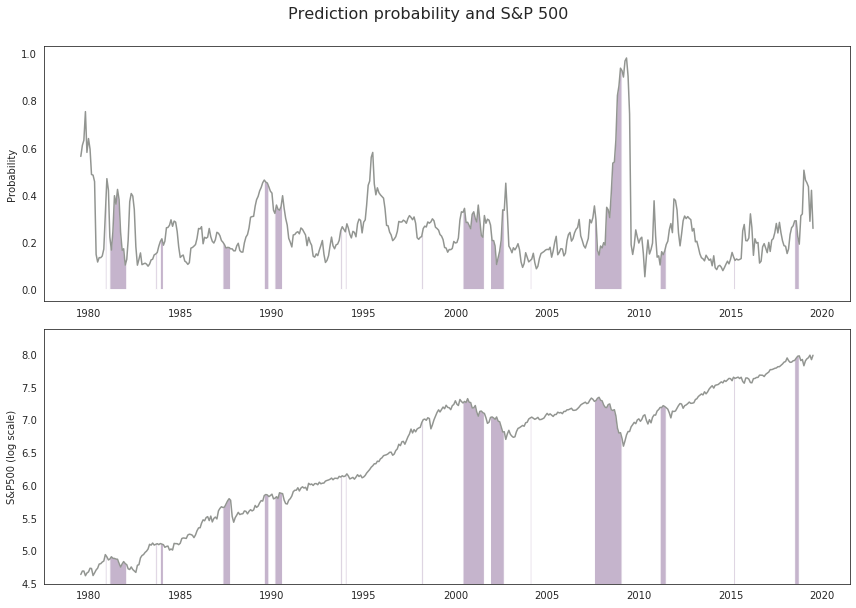

In [22]:
# Plot timeseries of SP500, prediction %, and y label shading
fig1, (ax1, ax2) = plt.subplots(nrows = 2)
fig1.suptitle('Prediction probability and S&P 500', size = 16).set_y(1.05)
fig1.subplots_adjust(top = 0.85)

ax1.plot(df_preds_coefs.index, df_preds_coefs['pred_prob'], 'k-', 
    color = sns.xkcd_rgb['grey'])
ax1.fill_between(
    df_preds_coefs.index, 
    df_preds_coefs['pred_prob'], 
    y2 = 0, 
    where = df_preds_coefs['y1']
    )
ax1.set_ylabel('Probability')

ax2.plot(df_preds_coefs.index, df_preds_coefs['close'], 'k-',
    color = sns.xkcd_rgb['grey'])
ax2.fill_between(
    df_preds_coefs.index, 
    df_preds_coefs['close'], 
    y2 = 0, 
    where = df_preds_coefs['y1']
    )
ax2.set_ylim(bottom = 4.5)
ax2.set_ylabel('S&P500 (log scale)')
fig1.tight_layout()

Our model is not very good at forecasting the drawdown in the S&P 500.  This is not surprising given the little time put into it.  

Lets now look at the regression parameters.

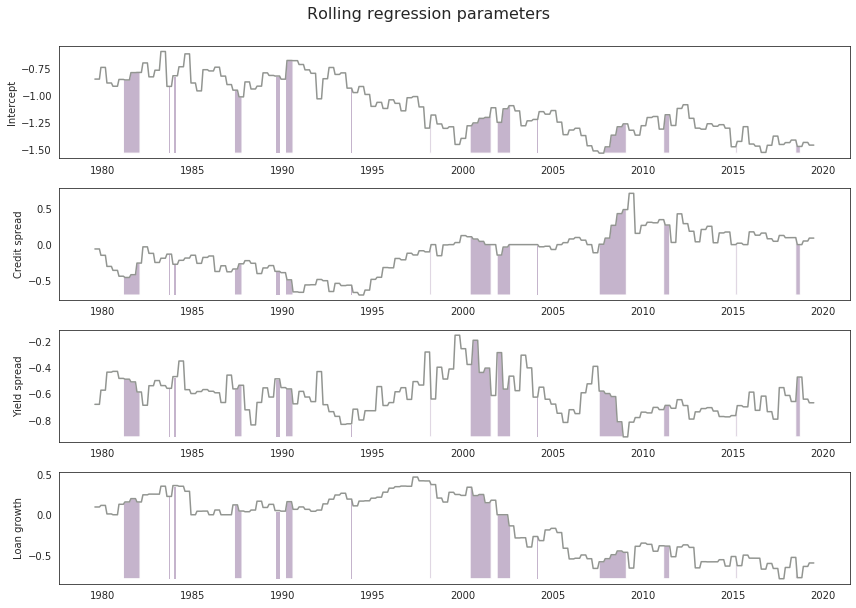

In [23]:
# Plot parameters
fig2, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 4)
fig2.suptitle('Rolling regression parameters', size = 16).set_y(1.05)
fig2.subplots_adjust(top = 0.85)

ax1.plot(df_preds_coefs.index, df_preds_coefs['Int_coef'], 'k-', 
    color = sns.xkcd_rgb['grey'])
ax1.fill_between(
    df_preds_coefs.index, 
    df_preds_coefs['Int_coef'], 
    y2 = df_preds_coefs['Int_coef'].min(), 
    where = df_preds_coefs['y1']
    )
ax1.set_ylabel('Intercept')

ax2.plot(df_preds_coefs.index, df_preds_coefs['CRED_SPRD_coef'], 'k-', 
    color = sns.xkcd_rgb['grey'])
ax2.fill_between(
    df_preds_coefs.index, 
    df_preds_coefs['CRED_SPRD_coef'], 
    y2 = df_preds_coefs['CRED_SPRD_coef'].min(),
    where = df_preds_coefs['y1']
    )
ax2.set_ylabel('Credit spread')

ax3.plot(df_preds_coefs.index, df_preds_coefs['YLD_SPRD_coef'], 'k-',
    color = sns.xkcd_rgb['grey'])
ax3.fill_between(
    df_preds_coefs.index, 
    df_preds_coefs['YLD_SPRD_coef'], 
    y2 = df_preds_coefs['YLD_SPRD_coef'].min(),
    where = df_preds_coefs['y1']
    )
ax3.set_ylabel('Yield spread')

ax4.plot(df_preds_coefs.index, df_preds_coefs['LOAN_GROWTH_coef'], 'k-',
    color = sns.xkcd_rgb['grey'])
ax4.fill_between(
    df_preds_coefs.index, 
    df_preds_coefs['LOAN_GROWTH_coef'], 
    y2 = df_preds_coefs['LOAN_GROWTH_coef'].min(),
    where = df_preds_coefs['y1']
    )
ax4.set_ylabel('Loan growth')

fig2.tight_layout()

## Conclusion

The code embedded in this notebook is working as expected.  We have produced a rolling out of sample rolling regression, capturing the prediction probability and regression parameters. 

The next steps for this piece of analysis is to embed an inner loop for nested cross validition.  This will enable the tuning model hyper-parameters in a time series context..


## References

https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9 
https://github.com/sam31415/timeseriescv/blob/master/timeseriescv/cross_validation.py  
https://hub.packtpub.com/cross-validation-strategies-for-time-series-forecasting-tutorial/  
https://www.mikulskibartosz.name/nested-cross-validation-in-time-series-forecasting-using-scikit-learn-and-statsmodels/  
https://arxiv.org/pdf/1905.11744.pdf
